In [1]:
import numpy as np
import math
import os
import tensorflow as tf
import keras
import keras.backend as K
from keras import regularizers

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout,Flatten,Concatenate, Masking
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [3]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.9

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [4]:
def mse_multiDim_loss(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true - y_pred),axis = -1, keepdims=True))

In [5]:
distance_frmMonitor = 70 #in cm
ScreenWidth = 60.77 #cms excluding bezel width
dispHoriRes = 2560
display = np.array([2560,1440])

deg_per_px = math.degrees(math.atan2(.5*ScreenWidth, distance_frmMonitor)) / (.5*dispHoriRes)

def visualDeg_err(y_true, y_pred):
    y_true_temp = y_true * display
    y_pred_temp = y_pred * display
    return (K.mean(K.sqrt(K.sum(K.square(y_true_temp - y_pred_temp), axis=-1, keepdims=True))) * deg_per_px)

In [6]:
#input data
import os
data_dir = r"F:\HCI\saarland\npy_allSaccades\\"
files = os.listdir(data_dir)
for f in files:
    file = data_dir + f
    if f== files[0]:
        data = np.load(file)
    else:
        data = np.vstack((data,np.load(file)))
        
#data = np.load(data_dir + "9.npy")
print(data.shape)

(15324, 11, 3)


In [7]:
#Hyper-parameters, constants
max_length_saccades = 10
learning_rate=0.00009
decay_rate = 1e-6

In [8]:
#format data
Input = data[:,0:max_length_saccades,:]
#y = data[:,-1,:]
y = data[:,-1,0:2]
print(Input.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(Input, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15324, 10, 3)
(15324, 2)
(12259, 10, 3)
(3065, 10, 3)
(12259, 2)
(3065, 2)


In [9]:
optimizer = keras.optimizers.Adam(lr=learning_rate,decay=decay_rate)
model = keras.models.Sequential()

layer1 = model.add(Masking(mask_value=100, input_shape=(max_length_saccades, 3),name = 'mask_layer'))

#layer2 = model.add(LSTM(32, return_sequences=True, input_shape=(max_length_saccades, 3)))
layer2 = model.add(LSTM(32, return_sequences=True,))


model.add(Dropout(0.27))

layer3 = model.add(LSTM(32,return_sequences=False,))  
# returns a sequence of vectors of dimension 32

model.add(Dropout(0.17))

output_layer = model.add(Dense(2, activation='linear',name = 'output_layers'))


model.compile(loss=mse_multiDim_loss,
              optimizer=optimizer,
              metrics=[visualDeg_err])
# Print summary
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(Input.shape))
print("Actual output: {}".format(y.shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mask_layer (Masking)         (None, 10, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            4608      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output_layers (Dense)        (None, 2)                 66        
Total params: 12,994
Trainable params: 12,994
Non-trainable params: 0
_________________________________________________________________
Inputs

In [10]:
#Fit the model to data
history = model.fit(x = X_train, y= y_train, batch_size= 32, epochs = 1500, verbose = 1, validation_data = (X_test, y_test), shuffle = True  )

Train on 12259 samples, validate on 3065 samples
Epoch 1/1500
12259/12259 [==============================] - 16s 1ms/step - loss: 0.4361 - visualDeg_err: 22.2305 - val_loss: 0.1910 - val_visualDeg_err: 16.0109
Epoch 2/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.2258 - visualDeg_err: 16.9730 - val_loss: 0.1855 - val_visualDeg_err: 15.8314
Epoch 3/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.2103 - visualDeg_err: 16.4689 - val_loss: 0.1783 - val_visualDeg_err: 15.5935
Epoch 4/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.1858 - visualDeg_err: 15.8116 - val_loss: 0.1439 - val_visualDeg_err: 14.4709
Epoch 5/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.1615 - visualDeg_err: 14.7467 - val_loss: 0.1192 - val_visualDeg_err: 12.4843
Epoch 6/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.1324 - visualDeg_err: 12.3899 - val_loss: 0.1039 - val_visualDe

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0694 - visualDeg_err: 7.9100 - val_loss: 0.0520 - val_visualDeg_err: 6.0018
Epoch 52/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0677 - visualDeg_err: 7.7712 - val_loss: 0.0515 - val_visualDeg_err: 5.9973
Epoch 53/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0683 - visualDeg_err: 7.7784 - val_loss: 0.0502 - val_visualDeg_err: 5.8163
Epoch 54/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0671 - visualDeg_err: 7.6956 - val_loss: 0.0509 - val_visualDeg_err: 5.9120
Epoch 55/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0668 - visualDeg_err: 7.6862 - val_loss: 0.0530 - val_visualDeg_err: 6.1790
Epoch 56/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0663 - visualDeg_err: 7.6335 - val_loss: 0.0511 - val_visualDeg_err: 5.9078
Epoch 57/1500
12259/12259 [===========================

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0542 - visualDeg_err: 6.5827 - val_loss: 0.0447 - val_visualDeg_err: 5.39048
Epoch 103/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0551 - visualDeg_err: 6.6518 - val_loss: 0.0422 - val_visualDeg_err: 5.1787
Epoch 104/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0548 - visualDeg_err: 6.6523 - val_loss: 0.0427 - val_visualDeg_err: 5.1299sualDeg_err: 6.6
Epoch 105/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0542 - visualDeg_err: 6.5966 - val_loss: 0.0427 - val_visualDeg_err: 5.1294
Epoch 106/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0547 - visualDeg_err: 6.6425 - val_loss: 0.0420 - val_visualDeg_err: 5.0845
Epoch 107/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0546 - visualDeg_err: 6.6222 - val_loss: 0.0416 - val_visualDeg_err: 5.0827
Epoch 108/1500
12259/12259 [====

Epoch 153/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0485 - visualDeg_err: 6.0900 - val_loss: 0.0379 - val_visualDeg_err: 4.7121
Epoch 154/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0485 - visualDeg_err: 6.1160 - val_loss: 0.0390 - val_visualDeg_err: 4.8527
Epoch 155/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0484 - visualDeg_err: 6.1232 - val_loss: 0.0388 - val_visualDeg_err: 4.8420
Epoch 156/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0477 - visualDeg_err: 6.0605 - val_loss: 0.0387 - val_visualDeg_err: 4.8079
Epoch 157/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0488 - visualDeg_err: 6.1172 - val_loss: 0.0382 - val_visualDeg_err: 4.8120
Epoch 158/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0486 - visualDeg_err: 6.1089 - val_loss: 0.0383 - val_visualDeg_err: 4.7027
Epoch 159/1500
12259/12259 [======

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0445 - visualDeg_err: 5.8086 - val_loss: 0.0371 - val_visualDeg_err: 4.7174
Epoch 204/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0443 - visualDeg_err: 5.7792 - val_loss: 0.0349 - val_visualDeg_err: 4.4287
Epoch 205/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0450 - visualDeg_err: 5.8270 - val_loss: 0.0352 - val_visualDeg_err: 4.5126
Epoch 206/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0449 - visualDeg_err: 5.8131 - val_loss: 0.0359 - val_visualDeg_err: 4.4632
Epoch 207/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0444 - visualDeg_err: 5.8045 - val_loss: 0.0352 - val_visualDeg_err: 4.4807
Epoch 208/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0431 - visualDeg_err: 5.6898 - val_loss: 0.0354 - val_visualDeg_err: 4.5656
Epoch 209/1500
12259/12259 [=====================

Epoch 254/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0414 - visualDeg_err: 5.5663 - val_loss: 0.0334 - val_visualDeg_err: 4.3247
Epoch 255/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0414 - visualDeg_err: 5.5550 - val_loss: 0.0359 - val_visualDeg_err: 4.6080
Epoch 256/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0416 - visualDeg_err: 5.5836 - val_loss: 0.0323 - val_visualDeg_err: 4.2245
Epoch 257/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0410 - visualDeg_err: 5.5440 - val_loss: 0.0331 - val_visualDeg_err: 4.3611
Epoch 258/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0417 - visualDeg_err: 5.5882 - val_loss: 0.0355 - val_visualDeg_err: 4.5370
Epoch 259/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0415 - visualDeg_err: 5.5706 - val_loss: 0.0320 - val_visualDeg_err: 4.2760
Epoch 260/1500
12259/12259 [======

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0388 - visualDeg_err: 5.3886 - val_loss: 0.0318 - val_visualDeg_err: 4.2611
Epoch 305/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0392 - visualDeg_err: 5.4011 - val_loss: 0.0312 - val_visualDeg_err: 4.1847
Epoch 306/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0391 - visualDeg_err: 5.4044 - val_loss: 0.0307 - val_visualDeg_err: 4.1725
Epoch 307/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0390 - visualDeg_err: 5.3966 - val_loss: 0.0312 - val_visualDeg_err: 4.1311
Epoch 308/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0393 - visualDeg_err: 5.3978 - val_loss: 0.0323 - val_visualDeg_err: 4.2472
Epoch 309/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0385 - visualDeg_err: 5.3316 - val_loss: 0.0312 - val_visualDeg_err: 4.1749
Epoch 310/1500
12259/12259 [=====================

Epoch 355/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0373 - visualDeg_err: 5.2629 - val_loss: 0.0303 - val_visualDeg_err: 4.1345
Epoch 356/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0371 - visualDeg_err: 5.2703 - val_loss: 0.0290 - val_visualDeg_err: 3.9711
Epoch 357/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0371 - visualDeg_err: 5.2457 - val_loss: 0.0296 - val_visualDeg_err: 4.0318
Epoch 358/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0374 - visualDeg_err: 5.2661 - val_loss: 0.0296 - val_visualDeg_err: 3.9580
Epoch 359/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0370 - visualDeg_err: 5.2606 - val_loss: 0.0294 - val_visualDeg_err: 4.0562
Epoch 360/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0377 - visualDeg_err: 5.3027 - val_loss: 0.0308 - val_visualDeg_err: 4.2478
Epoch 361/1500
12259/12259 [======

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0357 - visualDeg_err: 5.1318 - val_loss: 0.0289 - val_visualDeg_err: 4.0464
Epoch 406/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0352 - visualDeg_err: 5.1290 - val_loss: 0.0281 - val_visualDeg_err: 3.8867
Epoch 407/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0354 - visualDeg_err: 5.1187 - val_loss: 0.0279 - val_visualDeg_err: 3.9761
Epoch 408/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0348 - visualDeg_err: 5.0735 - val_loss: 0.0297 - val_visualDeg_err: 4.0417
Epoch 409/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0347 - visualDeg_err: 5.0812 - val_loss: 0.0279 - val_visualDeg_err: 3.9119
Epoch 410/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0353 - visualDeg_err: 5.1359 - val_loss: 0.0274 - val_visualDeg_err: 3.8490
Epoch 411/1500
12259/12259 [=====================

12259/12259 [==============================] - 13s 1ms/step - loss: 0.0343 - visualDeg_err: 5.0417 - val_loss: 0.0261 - val_visualDeg_err: 3.8062
Epoch 456/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0335 - visualDeg_err: 4.9865 - val_loss: 0.0266 - val_visualDeg_err: 3.8141
Epoch 457/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0338 - visualDeg_err: 4.9955 - val_loss: 0.0259 - val_visualDeg_err: 3.7628
Epoch 458/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0339 - visualDeg_err: 5.0316 - val_loss: 0.0266 - val_visualDeg_err: 3.8790
Epoch 459/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0339 - visualDeg_err: 5.0488 - val_loss: 0.0270 - val_visualDeg_err: 3.8687
Epoch 460/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0336 - visualDeg_err: 4.9908 - val_loss: 0.0270 - val_visualDeg_err: 3.9299
Epoch 461/1500
12259/12259 [=====================

12259/12259 [==============================] - 13s 1ms/step - loss: 0.0328 - visualDeg_err: 4.9408 - val_loss: 0.0264 - val_visualDeg_err: 3.7809
Epoch 506/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0326 - visualDeg_err: 4.9370 - val_loss: 0.0255 - val_visualDeg_err: 3.7903
Epoch 507/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0319 - visualDeg_err: 4.8759 - val_loss: 0.0252 - val_visualDeg_err: 3.7113
Epoch 508/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0324 - visualDeg_err: 4.9155 - val_loss: 0.0255 - val_visualDeg_err: 3.7151
Epoch 509/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0323 - visualDeg_err: 4.9033 - val_loss: 0.0260 - val_visualDeg_err: 3.7187
Epoch 510/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0326 - visualDeg_err: 4.9351 - val_loss: 0.0266 - val_visualDeg_err: 3.8379
Epoch 511/1500
12259/12259 [=====================

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0313 - visualDeg_err: 4.8231 - val_loss: 0.0243 - val_visualDeg_err: 3.6363
Epoch 555/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0310 - visualDeg_err: 4.8107 - val_loss: 0.0244 - val_visualDeg_err: 3.7366
Epoch 556/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0314 - visualDeg_err: 4.8389 - val_loss: 0.0268 - val_visualDeg_err: 3.8005
Epoch 557/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0310 - visualDeg_err: 4.8007 - val_loss: 0.0255 - val_visualDeg_err: 3.7820
Epoch 558/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0313 - visualDeg_err: 4.8247 - val_loss: 0.0242 - val_visualDeg_err: 3.6311
Epoch 559/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0308 - visualDeg_err: 4.8106 - val_loss: 0.0255 - val_visualDeg_err: 3.7066
Epoch 560/1500
12259/12259 [=====================

Epoch 605/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0303 - visualDeg_err: 4.7336 - val_loss: 0.0254 - val_visualDeg_err: 3.7472
Epoch 606/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0301 - visualDeg_err: 4.7573 - val_loss: 0.0241 - val_visualDeg_err: 3.7189
Epoch 607/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0306 - visualDeg_err: 4.8090 - val_loss: 0.0264 - val_visualDeg_err: 3.7874
Epoch 608/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0306 - visualDeg_err: 4.7661 - val_loss: 0.0242 - val_visualDeg_err: 3.6493
Epoch 609/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0308 - visualDeg_err: 4.7916 - val_loss: 0.0240 - val_visualDeg_err: 3.6441
Epoch 610/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0301 - visualDeg_err: 4.7650 - val_loss: 0.0259 - val_visualDeg_err: 3.8412
Epoch 611/1500
12259/12259 [======

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0291 - visualDeg_err: 4.6879 - val_loss: 0.0235 - val_visualDeg_err: 3.6797
Epoch 656/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0294 - visualDeg_err: 4.7012 - val_loss: 0.0238 - val_visualDeg_err: 3.6242
Epoch 657/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0297 - visualDeg_err: 4.7077 - val_loss: 0.0233 - val_visualDeg_err: 3.6017
Epoch 658/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0294 - visualDeg_err: 4.7103 - val_loss: 0.0243 - val_visualDeg_err: 3.6469
Epoch 659/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0293 - visualDeg_err: 4.6974 - val_loss: 0.0240 - val_visualDeg_err: 3.5882
Epoch 660/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0296 - visualDeg_err: 4.6784 - val_loss: 0.0232 - val_visualDeg_err: 3.6037
Epoch 661/1500
12259/12259 [=====================

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0285 - visualDeg_err: 4.6065 - val_loss: 0.0232 - val_visualDeg_err: 3.5612
Epoch 706/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0291 - visualDeg_err: 4.6669 - val_loss: 0.0227 - val_visualDeg_err: 3.5610
Epoch 707/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0286 - visualDeg_err: 4.6170 - val_loss: 0.0236 - val_visualDeg_err: 3.5768
Epoch 708/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0286 - visualDeg_err: 4.6322 - val_loss: 0.0238 - val_visualDeg_err: 3.5900
Epoch 709/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0289 - visualDeg_err: 4.6488 - val_loss: 0.0250 - val_visualDeg_err: 3.6600
Epoch 710/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0288 - visualDeg_err: 4.6578 - val_loss: 0.0232 - val_visualDeg_err: 3.6251
Epoch 711/1500
12259/12259 [=====================

Epoch 756/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0287 - visualDeg_err: 4.6328 - val_loss: 0.0227 - val_visualDeg_err: 3.5019
Epoch 757/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0283 - visualDeg_err: 4.5796 - val_loss: 0.0226 - val_visualDeg_err: 3.5589
Epoch 758/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0278 - visualDeg_err: 4.5530 - val_loss: 0.0226 - val_visualDeg_err: 3.4684
Epoch 759/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0283 - visualDeg_err: 4.6165 - val_loss: 0.0229 - val_visualDeg_err: 3.5300
Epoch 760/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0280 - visualDeg_err: 4.5931 - val_loss: 0.0229 - val_visualDeg_err: 3.5256
Epoch 761/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0280 - visualDeg_err: 4.5770 - val_loss: 0.0227 - val_visualDeg_err: 3.6007
Epoch 762/1500
12259/12259 [======

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0275 - visualDeg_err: 4.5343 - val_loss: 0.0229 - val_visualDeg_err: 3.5805
Epoch 807/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0274 - visualDeg_err: 4.5434 - val_loss: 0.0230 - val_visualDeg_err: 3.5601
Epoch 808/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0277 - visualDeg_err: 4.5504 - val_loss: 0.0233 - val_visualDeg_err: 3.5295
Epoch 809/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0275 - visualDeg_err: 4.5602 - val_loss: 0.0227 - val_visualDeg_err: 3.5951
Epoch 810/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0279 - visualDeg_err: 4.5989 - val_loss: 0.0225 - val_visualDeg_err: 3.4729
Epoch 811/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0276 - visualDeg_err: 4.5382 - val_loss: 0.0221 - val_visualDeg_err: 3.4407
Epoch 812/1500
12259/12259 [=====================

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0274 - visualDeg_err: 4.5483 - val_loss: 0.0217 - val_visualDeg_err: 3.4272
Epoch 857/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0273 - visualDeg_err: 4.5448 - val_loss: 0.0228 - val_visualDeg_err: 3.5394
Epoch 858/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0273 - visualDeg_err: 4.5104 - val_loss: 0.0222 - val_visualDeg_err: 3.4578
Epoch 859/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0274 - visualDeg_err: 4.5414 - val_loss: 0.0221 - val_visualDeg_err: 3.5010
Epoch 860/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0271 - visualDeg_err: 4.4944 - val_loss: 0.0220 - val_visualDeg_err: 3.4776
Epoch 861/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0272 - visualDeg_err: 4.5176 - val_loss: 0.0222 - val_visualDeg_err: 3.4613
Epoch 862/1500
12259/12259 [=====================

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0268 - visualDeg_err: 4.4911 - val_loss: 0.0245 - val_visualDeg_err: 3.6677
Epoch 907/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0273 - visualDeg_err: 4.5190 - val_loss: 0.0227 - val_visualDeg_err: 3.4947
Epoch 908/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0270 - visualDeg_err: 4.4961 - val_loss: 0.0225 - val_visualDeg_err: 3.5274
Epoch 909/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0267 - visualDeg_err: 4.4635 - val_loss: 0.0219 - val_visualDeg_err: 3.4668
Epoch 910/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0265 - visualDeg_err: 4.4676 - val_loss: 0.0219 - val_visualDeg_err: 3.4174
Epoch 911/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0270 - visualDeg_err: 4.5091 - val_loss: 0.0224 - val_visualDeg_err: 3.4922
Epoch 912/1500
12259/12259 [=====================

Epoch 957/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0262 - visualDeg_err: 4.4472 - val_loss: 0.0222 - val_visualDeg_err: 3.4747
Epoch 958/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0267 - visualDeg_err: 4.4686 - val_loss: 0.0223 - val_visualDeg_err: 3.4334
Epoch 959/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0262 - visualDeg_err: 4.4498 - val_loss: 0.0217 - val_visualDeg_err: 3.4277
Epoch 960/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0263 - visualDeg_err: 4.4316 - val_loss: 0.0218 - val_visualDeg_err: 3.4673
Epoch 961/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0266 - visualDeg_err: 4.4492 - val_loss: 0.0221 - val_visualDeg_err: 3.4763
Epoch 962/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0262 - visualDeg_err: 4.4105 - val_loss: 0.0217 - val_visualDeg_err: 3.4108
Epoch 963/1500
12259/12259 [======

12259/12259 [==============================] - 13s 1ms/step - loss: 0.0260 - visualDeg_err: 4.4142 - val_loss: 0.0217 - val_visualDeg_err: 3.4202
Epoch 1008/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0264 - visualDeg_err: 4.4424 - val_loss: 0.0227 - val_visualDeg_err: 3.4816
Epoch 1009/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0262 - visualDeg_err: 4.4285 - val_loss: 0.0217 - val_visualDeg_err: 3.4536
Epoch 1010/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0262 - visualDeg_err: 4.4473 - val_loss: 0.0215 - val_visualDeg_err: 3.4205
Epoch 1011/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0263 - visualDeg_err: 4.4302 - val_loss: 0.0215 - val_visualDeg_err: 3.4494
Epoch 1012/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0264 - visualDeg_err: 4.4315 - val_loss: 0.0216 - val_visualDeg_err: 3.3892
Epoch 1013/1500
12259/12259 [===============

12259/12259 [==============================] - 13s 1ms/step - loss: 0.0258 - visualDeg_err: 4.4038 - val_loss: 0.0216 - val_visualDeg_err: 3.4283
Epoch 1058/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0257 - visualDeg_err: 4.3800 - val_loss: 0.0214 - val_visualDeg_err: 3.3928
Epoch 1059/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0264 - visualDeg_err: 4.4359 - val_loss: 0.0212 - val_visualDeg_err: 3.4168
Epoch 1060/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0260 - visualDeg_err: 4.4147 - val_loss: 0.0223 - val_visualDeg_err: 3.4837
Epoch 1061/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0261 - visualDeg_err: 4.4068 - val_loss: 0.0223 - val_visualDeg_err: 3.4376
Epoch 1062/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0256 - visualDeg_err: 4.4024 - val_loss: 0.0212 - val_visualDeg_err: 3.3771
Epoch 1063/1500
12259/12259 [===============

12259/12259 [==============================] - 13s 1ms/step - loss: 0.0256 - visualDeg_err: 4.3729 - val_loss: 0.0218 - val_visualDeg_err: 3.4153
Epoch 1108/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0253 - visualDeg_err: 4.3500 - val_loss: 0.0219 - val_visualDeg_err: 3.4505
Epoch 1109/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0254 - visualDeg_err: 4.3578 - val_loss: 0.0223 - val_visualDeg_err: 3.4589
Epoch 1110/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0256 - visualDeg_err: 4.3797 - val_loss: 0.0214 - val_visualDeg_err: 3.4661
Epoch 1111/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0258 - visualDeg_err: 4.3879 - val_loss: 0.0210 - val_visualDeg_err: 3.3667
Epoch 1112/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0259 - visualDeg_err: 4.3691 - val_loss: 0.0225 - val_visualDeg_err: 3.4643
Epoch 1113/1500
12259/12259 [===============

12259/12259 [==============================] - 13s 1ms/step - loss: 0.0251 - visualDeg_err: 4.3277 - val_loss: 0.0218 - val_visualDeg_err: 3.4790
Epoch 1158/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0254 - visualDeg_err: 4.3535 - val_loss: 0.0215 - val_visualDeg_err: 3.3718
Epoch 1159/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0252 - visualDeg_err: 4.3370 - val_loss: 0.0218 - val_visualDeg_err: 3.4544
Epoch 1160/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0258 - visualDeg_err: 4.4112 - val_loss: 0.0215 - val_visualDeg_err: 3.3842
Epoch 1161/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0255 - visualDeg_err: 4.3602 - val_loss: 0.0214 - val_visualDeg_err: 3.4228
Epoch 1162/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0252 - visualDeg_err: 4.3476 - val_loss: 0.0212 - val_visualDeg_err: 3.3605
Epoch 1163/1500
12259/12259 [===============

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0256 - visualDeg_err: 4.3838 - val_loss: 0.0219 - val_visualDeg_err: 3.4832
Epoch 1208/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0249 - visualDeg_err: 4.3068 - val_loss: 0.0212 - val_visualDeg_err: 3.4063
Epoch 1209/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0250 - visualDeg_err: 4.3383 - val_loss: 0.0210 - val_visualDeg_err: 3.3738
Epoch 1210/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0253 - visualDeg_err: 4.3807 - val_loss: 0.0211 - val_visualDeg_err: 3.3602
Epoch 1211/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0251 - visualDeg_err: 4.3431 - val_loss: 0.0213 - val_visualDeg_err: 3.4234
Epoch 1212/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0253 - visualDeg_err: 4.3513 - val_loss: 0.0210 - val_visualDeg_err: 3.4115
Epoch 1213/1500
12259/12259 [===============

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0246 - visualDeg_err: 4.2914 - val_loss: 0.0208 - val_visualDeg_err: 3.3568
Epoch 1258/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0249 - visualDeg_err: 4.3077 - val_loss: 0.0213 - val_visualDeg_err: 3.4293
Epoch 1259/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0249 - visualDeg_err: 4.3233 - val_loss: 0.0211 - val_visualDeg_err: 3.3965
Epoch 1260/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0250 - visualDeg_err: 4.3168 - val_loss: 0.0212 - val_visualDeg_err: 3.4277
Epoch 1261/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0250 - visualDeg_err: 4.3301 - val_loss: 0.0211 - val_visualDeg_err: 3.3938- loss: 0.0249 - visualDeg_err: 
Epoch 1262/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0249 - visualDeg_err: 4.3210 - val_loss: 0.0214 - val_visualDeg_err: 3.3926
Epoch 1263/1

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0247 - visualDeg_err: 4.3227 - val_loss: 0.0209 - val_visualDeg_err: 3.3298
Epoch 1308/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0253 - visualDeg_err: 4.3450 - val_loss: 0.0210 - val_visualDeg_err: 3.3355
Epoch 1309/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0247 - visualDeg_err: 4.2963 - val_loss: 0.0211 - val_visualDeg_err: 3.3740
Epoch 1310/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0246 - visualDeg_err: 4.3043 - val_loss: 0.0209 - val_visualDeg_err: 3.3261
Epoch 1311/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0246 - visualDeg_err: 4.2869 - val_loss: 0.0209 - val_visualDeg_err: 3.3560
Epoch 1312/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0246 - visualDeg_err: 4.3018 - val_loss: 0.0213 - val_visualDeg_err: 3.3891
Epoch 1313/1500
12259/12259 [===============

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0243 - visualDeg_err: 4.2616 - val_loss: 0.0211 - val_visualDeg_err: 3.3572
Epoch 1358/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0246 - visualDeg_err: 4.2842 - val_loss: 0.0210 - val_visualDeg_err: 3.3743
Epoch 1359/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0245 - visualDeg_err: 4.2959 - val_loss: 0.0211 - val_visualDeg_err: 3.3452
Epoch 1360/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0247 - visualDeg_err: 4.3145 - val_loss: 0.0213 - val_visualDeg_err: 3.3970
Epoch 1361/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0248 - visualDeg_err: 4.3383 - val_loss: 0.0221 - val_visualDeg_err: 3.3897
Epoch 1362/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0244 - visualDeg_err: 4.2669 - val_loss: 0.0213 - val_visualDeg_err: 3.3429
Epoch 1363/1500
12259/12259 [===============

12259/12259 [==============================] - 14s 1ms/step - loss: 0.0242 - visualDeg_err: 4.2625 - val_loss: 0.0207 - val_visualDeg_err: 3.3307
Epoch 1408/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0243 - visualDeg_err: 4.2864 - val_loss: 0.0212 - val_visualDeg_err: 3.4118
Epoch 1409/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0245 - visualDeg_err: 4.2829 - val_loss: 0.0208 - val_visualDeg_err: 3.3456
Epoch 1410/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0239 - visualDeg_err: 4.2568 - val_loss: 0.0215 - val_visualDeg_err: 3.3588
Epoch 1411/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0241 - visualDeg_err: 4.2750 - val_loss: 0.0215 - val_visualDeg_err: 3.4351
Epoch 1412/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0246 - visualDeg_err: 4.2823 - val_loss: 0.0208 - val_visualDeg_err: 3.3217
Epoch 1413/1500
12259/12259 [===============

12259/12259 [==============================] - 13s 1ms/step - loss: 0.0243 - visualDeg_err: 4.2711 - val_loss: 0.0209 - val_visualDeg_err: 3.3574
Epoch 1458/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0245 - visualDeg_err: 4.3017 - val_loss: 0.0207 - val_visualDeg_err: 3.3418
Epoch 1459/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0245 - visualDeg_err: 4.2937 - val_loss: 0.0207 - val_visualDeg_err: 3.3711
Epoch 1460/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0243 - visualDeg_err: 4.2839 - val_loss: 0.0206 - val_visualDeg_err: 3.3021
Epoch 1461/1500
12259/12259 [==============================] - 14s 1ms/step - loss: 0.0240 - visualDeg_err: 4.2348 - val_loss: 0.0208 - val_visualDeg_err: 3.3399
Epoch 1462/1500
12259/12259 [==============================] - 13s 1ms/step - loss: 0.0239 - visualDeg_err: 4.2436 - val_loss: 0.0209 - val_visualDeg_err: 3.3485
Epoch 1463/1500
12259/12259 [===============

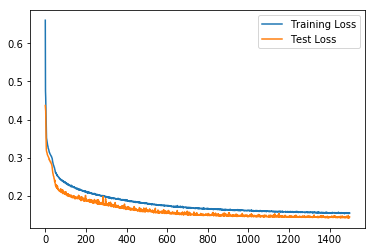

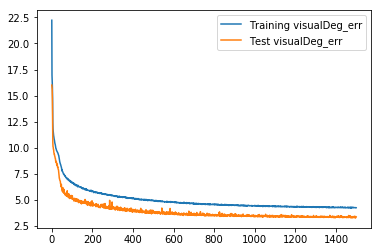

In [19]:
import matplotlib.pyplot as plt
#693/693 [==============================] - 0s 660us/step - loss: 0.0143 - val_loss: 0.0389
vDeg_test = (history.history['val_visualDeg_err'])
vDeg_train = (history.history['visualDeg_err'])
l_test = np.sqrt(history.history['val_loss'])
l_train = np.sqrt(history.history['loss'])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(l_train, label="Training Loss")
ax.plot(l_test, label="Test Loss")
ax.legend()

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(vDeg_train, label="Training visualDeg_err")
ax1.plot(vDeg_test, label="Test visualDeg_err")
ax1.legend()

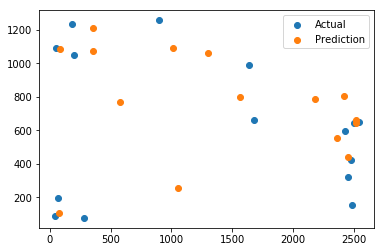

In [20]:
#model.outputs[0]
#m.outputs = 
display = [2560,1440]   
y_pred = model.predict(Input)

start = 5
end = 20
plt.scatter(y[start:end,0]*display[0],y[start:end,1]*display[1],label = "Actual")
plt.scatter(y_pred[start:end,0]*display[0],y_pred[start:end,1]*display[1], label = "Prediction")
plt.legend()

([array([1966., 2164., 1640., 1181.,  954.,  882.,  994., 1486., 2388.,
         1669.]),
  array([ 789., 1883., 2160., 1670., 1508., 1574., 1755., 2088., 1547.,
          350.])],
 array([-0.00521237,  0.09755071,  0.20031378,  0.30307686,  0.40583992,
         0.508603  ,  0.6113661 ,  0.71412915,  0.8168922 ,  0.9196553 ,
         1.0224184 ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

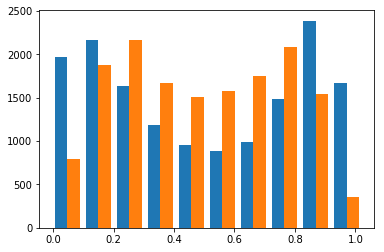

In [21]:
plt.hist(y_pred)

([array([2746., 1741., 1215., 1109., 1167., 1074., 1027.,  991., 1618.,
         2636.]),
  array([1284., 1964., 1745., 1560., 1367., 1360., 1442., 1623., 1852.,
         1127.])],
 array([7.66500000e-05, 1.00068135e-01, 2.00059620e-01, 3.00051105e-01,
        4.00042590e-01, 5.00034075e-01, 6.00025560e-01, 7.00017045e-01,
        8.00008530e-01, 9.00000015e-01, 9.99991500e-01]),
 <a list of 2 Lists of Patches objects>)

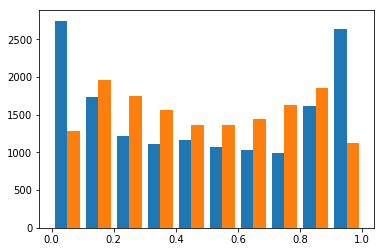

In [22]:
plt.hist(y)

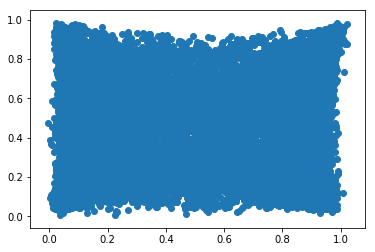

In [23]:
plt.scatter(y_pred[:,0],y_pred[:,1])

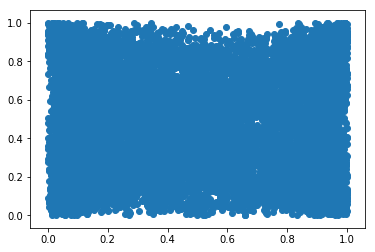

In [24]:
plt.scatter(y[:,0],y[:,1])

In [25]:
model.save("model_mask_09012019.h5")

In [26]:
model.save("model_mask_noOpt_09012019.h5",include_optimizer=False)